# Samuel Watkins, 3032132676

# HW 5: Database
## Weather Prediction, due Monday Mar 12, 2018 at 2 PM

In this assignment, we will create a database to analyze historical weather data and discover the relationships between major cities.

1. Find a list of the 50 most travelled airports in the US and make a table containing the relevant information, such as name, nearest city, latitude, and longitude.
2. Build another table that will hold historical weather information, such as min/max temperature, humidity, and precipitation.
3. Build a web crawler that will pull historical data from Weather Underground from 2008 until now and populate your tables accordingly.
4. For each pair of cities/airports, determine how the daily change of temperature high and precipitation from one city predicts the daily change of the other city 1, 3, and 7 days in advance.
5. Plot the correlation strengths for the 10 top pairs for all three dates for temperature and precipitation (separately) as a function of distance. Also, make a plot as a function of longitude. What trends do you see?

# 1. List of 50 Most Travelled Airports

A list of all airports with latitude, longitude, altitude, codes, and more was found at [this link](https://openflights.org/data.html). A CSV can be downloaded that contains all of the information, called `airports.dat`.  
A list of the 50 most travelled airports in the US was found at [this link](https://www.rita.dot.gov/bts/sites/rita.dot.gov.bts/files/publications/national_transportation_statistics/html/table_01_44.html/). A CSV can be downloaded called `table_01_44_5.csv`, which contains the airport name, closest city, and the airport code.

In [1]:
import pandas as pd
import sqlite3

In [ ]:
# read the CSV containing the codes of the 50 most travelled airports
most_travelled_airports = pd.read_csv('table_01_44_5.csv',sep=',',skiprows=4,
                                      usecols=[1],names=["IATA Code"],skipfooter=11,engine="python")

# read the CSV containing information on all airports
all_airports = pd.read_csv('airports.dat',sep=',',usecols=[1,2,3,4,5,6,7,8],
                           names=["Name","City","Country","IATA Code","ICAO Code","Latitude","Longitude","Altitude"])

# merge the CSVs such that we have all relevant information necessary on the 50 most travelled airports
most_travelled_airports = most_travelled_airports.merge(all_airports,how="left",on="IATA Code")

In [2]:
connection = sqlite3.connect("airport_data.db")
cursor = connection.cursor()

In [ ]:
# let's create an airports table to store all of the information

sql_cmd = """CREATE TABLE airports (aid INTEGER PRIMARY KEY AUTOINCREMENT,
    name TEXT, city TEXT, country TEXT, iata TEXT, icao TEXT, latitude FLOAT, longitude FLOAT, altitude FLOAT)"""

cursor.execute(sql_cmd)

# now populate the table
for ii,row in most_travelled_airports.iterrows():
    name = row["Name"].replace("'","`")
    city = row["City"]
    country = row["Country"]
    icao = row["ICAO Code"]
    iata = row["IATA Code"]
    latitude = row["Latitude"]
    longitude = row["Longitude"]
    altitude = row["Altitude"]
    
    sql_cmd = "INSERT INTO airports" + \
              "(name, city, country, iata, icao, latitude, longitude, altitude)" + \
              f""" VALUES ('{name}','{city}','{country}','{iata}','{icao}',{latitude},{longitude},{altitude})"""
    cursor.execute(sql_cmd)
connection.commit()


# 2. Table for Storing Weather Information

In [ ]:
sql_cmd = """CREATE TABLE weather (wid INTEGER PRIMARY KEY AUTOINCREMENT, aid INTEGER, date DATE,
    mintemp FLOAT, maxtemp FLOAT, meantemp FLOAT, precip FLOAT, windspeed FLOAT, humidity FLOAT)"""

cursor.execute(sql_cmd);

In [ ]:
# sql_cmd = """DROP TABLE weather"""

# cursor.execute(sql_cmd);

# 3. Web Crawler To Populate Weather Table

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import datetime

In [ ]:
years = 10
daysInYear = 365.24
dateToday = datetime.datetime.today()

sql_cmd = """SELECT airports.aid,airports.icao FROM airports """

cursor.execute(sql_cmd);
airport_names = cursor.fetchall()

for aid, airport_name in airport_names:
    
    dateLast = datetime.datetime.today() - datetime.timedelta(days=years*daysInYear)

    for _ in range(years):
        dateNext = dateLast + datetime.timedelta(days=daysInYear)

        if dateNext > datetime.datetime.today():
            dateNext = datetime.datetime.today()

        date_range = pd.date_range(start=dateLast,end=dateNext)
        
        urlDateStart = dateLast.strftime("%Y/%m/%d")
        urlDateEnd = dateNext.strftime("dayend=%d&monthend=%m&yearend=%Y")
        url = f"https://www.wunderground.com/history/airport/{airport_name}/{urlDateStart}/"+\
              f"CustomHistory.html?{urlDateEnd}"
        response = urlopen(url)
        html = response.read()
        response.close()
        soup = BeautifulSoup(html,"html.parser")


        for date in date_range:

            urlSingleDate = date.strftime("%Y/%-m/%-d")
            sqlDate = date.strftime("%Y-%m-%d")

            dataID = soup.select(f'a[href="/history/airport/{airport_name}/{urlSingleDate}/DailyHistory.html"]')
            if len(dataID)>0:
                row = dataID[0].find_all_next("td",limit=19)
                
                values = list()
                for value in row:
                    if value.get_text().replace('\n','').replace(' ','') == '-':
                        values.append("NULL")
                    elif value.get_text().replace('\n','').replace(' ','') == 'T':
                        values.append(0.0) # assume 0 inches of precipitation when trace precipitation is measured
                    else:
                        values.append(float(value.get_text().replace('\n','').replace(' ','')))
                
                maxtemp = values[0]
                meantemp = values[1]
                mintemp = values[2]
                humidity = values[7]
                windspeed = values[16]
                precip = values[18]
                
            else:
                # there is no data for this date
                maxtemp = "NULL"
                meantemp = "NULL"
                mintemp = "NULL"
                humidity = "NULL"
                windspeed = "NULL"
                precip = "NULL"
            
            sql_cmd = "INSERT INTO weather" + \
                      "(aid, date, mintemp, maxtemp, meantemp, precip, windspeed,humidity)" + \
                      f""" VALUES ({aid},'{sqlDate}',{mintemp},{maxtemp},{maxtemp},{precip},{windspeed},{humidity})"""
            
            cursor.execute(sql_cmd);
        dateLast = dateNext + datetime.timedelta(days=1)
connection.commit()


# 4. Predicting Changes in Weather

In [16]:
import numpy as np
import itertools

In [5]:
sql_cmd = """SELECT airports.aid FROM airports"""
cursor.execute(sql_cmd)

aids = np.concatenate(np.array(cursor.fetchall()))
combs = np.array(list(itertools.permutations(aids,2)))
nCombs = len(combs)

maxTempCorrs = np.zeros((len(combs),3))
precipCorrs = np.zeros((len(combs),3))

for iComb in range(nCombs):
# iComb = 12
    comb = combs[iComb]

    db_data = list()

    for ii in range(2):
        sql_cmd = f"""SELECT weather.maxtemp,weather.precip FROM weather 
                     WHERE weather.aid = {comb[ii]}"""

        cursor.execute(sql_cmd);
        db_data.append(np.array(cursor.fetchall()))

    db_data = np.hstack(np.array(db_data,dtype=np.float))

    combData = pd.DataFrame(db_data,columns=["maxtemp1","precip1","maxtemp2","precip2"]).dropna()
    
    maxTempCorr1 = np.corrcoef(combData.maxtemp1.diff().dropna().values[:-1],
                               y=combData.maxtemp2.diff().dropna().values[1:])[0,1]
    
    maxTempCorr3 = np.corrcoef(combData.maxtemp1.diff().dropna().values[:-3],
                               y=combData.maxtemp2.diff().dropna().values[3:])[0,1]
    
    maxTempCorr7 = np.corrcoef(combData.maxtemp1.diff().dropna().values[:-7],
                               y=combData.maxtemp2.diff().dropna().values[7:])[0,1]
    
    maxTempCorrs[iComb,:] = np.array([maxTempCorr1,maxTempCorr3,maxTempCorr7])
    
    precipCorr1 = np.corrcoef(combData.precip1.diff().dropna().values[:-1],
                                 y=combData.precip1.diff().dropna().values[1:])[0,1]
    
    precipCorr3 = np.corrcoef(combData.precip1.diff().dropna().values[:-3],
                                 y=combData.precip1.diff().dropna().values[3:])[0,1]
    
    precipCorr7 = np.corrcoef(combData.precip1.diff().dropna().values[:-7],
                                 y=combData.precip1.diff().dropna().values[7:])[0,1]
    
    precipCorrs[iComb,:] = np.array([precipCorr1,precipCorr3,precipCorr7])

# 5. Plotting the Results

In [13]:
import matplotlib.pyplot as plt
% matplotlib inline

def distanceOnSphere(lat1,lon1,lat2,lon2):
    # takes in latitude and longitude of two points in degrees,
    # outputs the great circle distance using the haversine formula (see Wikipedia)
    
    rEarth = 6371000.0 # radius of Earth in meters
    
    lat1*=np.pi/180
    lon1*=np.pi/180
    lat2*=np.pi/180
    lon2*=np.pi/180
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2.0 + np.cos(lat1)*np.cos(lat2) * np.sin(dlon/2)**2.0
    d = 2 * rEarth * np.sqrt(a)
    return d

nMax = 10

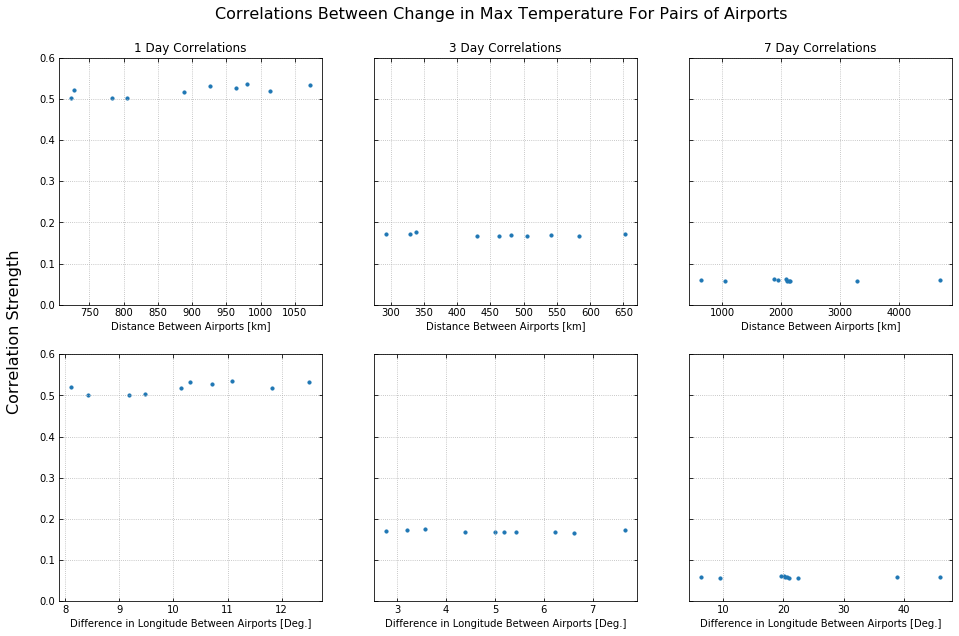

In [14]:
fig, ax = plt.subplots(2, 3, sharey='row',figsize=(16,10))
fig.text(0.08, 0.5, 'Correlation Strength', va='center', rotation='vertical',fontsize=16)
fig.text(0.26, 0.94, 'Correlations Between Change in Max Temperature For Pairs of Airports',va='center',fontsize=16)

labels = ["1 Day Correlations","3 Day Correlations","7 Day Correlations"]

for iDiff in range(3):
    
    corrStrength = abs(maxTempCorrs[:,iDiff])
    maxInds = corrStrength.argsort()[::-1][:nMax]
    bestCombs = combs[maxInds]
    distances = np.zeros(nMax)
    dlongitude = np.zeros(nMax)
    

    for iMax in range(nMax):
        comb = bestCombs[iMax]
        latlon = np.zeros((2,2))
        for iComb in range(2):
            sql_cmd = f"""SELECT airports.latitude,airports.longitude FROM airports 
                         WHERE airports.aid = {comb[iComb]}"""

            cursor.execute(sql_cmd);
            latlon[iComb] = np.array(cursor.fetchall(),dtype = np.float)
        distances[iMax] = distanceOnSphere(latlon[0,0],latlon[0,1],latlon[1,0],latlon[1,1])
        dlongitude[iMax] = abs(latlon[0,1]-latlon[1,1])
        
    ax[0,iDiff].scatter(distances*1e-3,corrStrength[maxInds],s=10.0)
    ax[0,iDiff].tick_params(which="both",top="on",right="on",direction="in")
    ax[0,iDiff].grid(linestyle="dotted")
    ax[0,iDiff].set_title(labels[iDiff])
    ax[0,iDiff].set_xlabel("Distance Between Airports [km]")
    ax[0,iDiff].set_ylim([0,0.6])
    
    ax[1,iDiff].scatter(dlongitude,corrStrength[maxInds],s=10.0)
    ax[1,iDiff].tick_params(which="both",top="on",right="on",direction="in")
    ax[1,iDiff].grid(linestyle="dotted")
    ax[1,iDiff].set_xlabel("Difference in Longitude Between Airports [Deg.]")
    ax[1,iDiff].set_ylim([0,0.6])
    

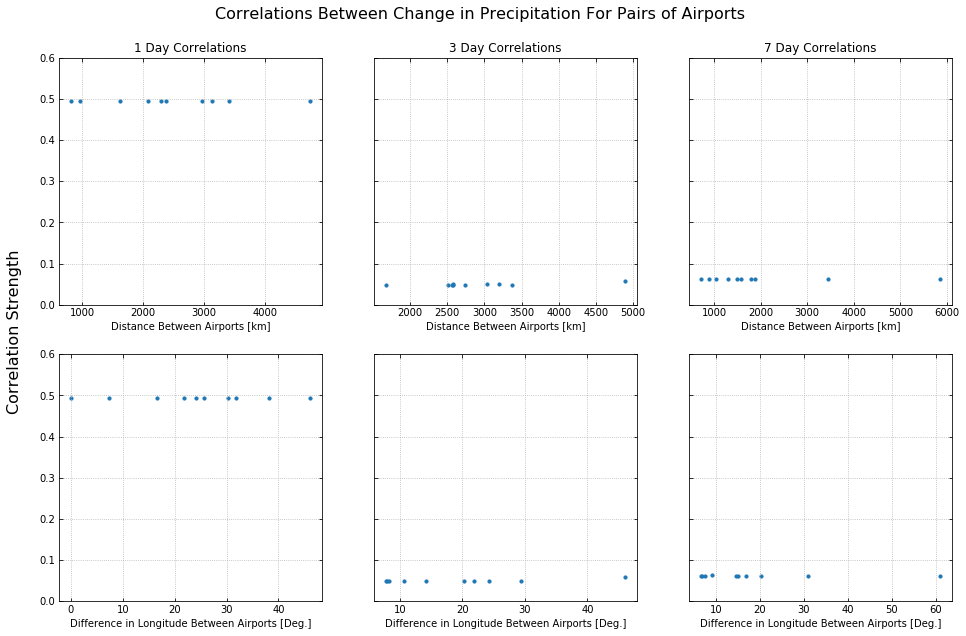

In [15]:
fig, ax = plt.subplots(2, 3, sharey='row',figsize=(16,10))
fig.text(0.08, 0.5, 'Correlation Strength', va='center', rotation='vertical',fontsize=16)
fig.text(0.26, 0.94, 'Correlations Between Change in Precipitation For Pairs of Airports',va='center',fontsize=16)

labels = ["1 Day Correlations","3 Day Correlations","7 Day Correlations"]

for iDiff in range(3):
    
    corrStrength = abs(precipCorrs[:,iDiff])
    maxInds = corrStrength.argsort()[::-1][:nMax]
    bestCombs = combs[maxInds]
    distances = np.zeros(nMax)
    dlongitude = np.zeros(nMax)
    

    for iMax in range(nMax):
        comb = bestCombs[iMax]
        latlon = np.zeros((2,2))
        for iComb in range(2):
            sql_cmd = f"""SELECT airports.latitude,airports.longitude FROM airports 
                         WHERE airports.aid = {comb[iComb]}"""

            cursor.execute(sql_cmd);
            latlon[iComb] = np.array(cursor.fetchall(),dtype = np.float)
        distances[iMax] = distanceOnSphere(latlon[0,0],latlon[0,1],latlon[1,0],latlon[1,1])
        dlongitude[iMax] = abs(latlon[0,1]-latlon[1,1])
        
    ax[0,iDiff].scatter(distances*1e-3,corrStrength[maxInds],s=10.0)
    ax[0,iDiff].tick_params(which="both",top="on",right="on",direction="in")
    ax[0,iDiff].grid(linestyle="dotted")
    ax[0,iDiff].set_title(labels[iDiff])
    ax[0,iDiff].set_xlabel("Distance Between Airports [km]")
    ax[0,iDiff].set_ylim([0,0.6])
    
    ax[1,iDiff].scatter(dlongitude,corrStrength[maxInds],s=10.0)
    ax[1,iDiff].tick_params(which="both",top="on",right="on",direction="in")
    ax[1,iDiff].grid(linestyle="dotted")
    ax[1,iDiff].set_xlabel("Difference in Longitude Between Airports [Deg.]")
    ax[1,iDiff].set_ylim([0,0.6])